# CEM gas usage

## Version
* 2019-05-31: Updated with new revised bill (from 2073.69 at 20% VAT to 1728.60 at 5% VAT); calculation in kWh instead of meter units for "readings", and estimate of annual usage and bill.
* 2019-05-15: First report.

## Data

The data is located in our sharepoint site. It includes all the actual readings and all estimates used in the bills.

The conversion from units to kWh is described in the bills by the following steps:
1. Convert the units into cubic meters - multiplying by 2.83
2. Multiply the cubic meters by the Correction Factor 1.02264
3. Multiply this by the Calorific Value 39.10
4. Divide this by 3.6 to convert to kWh

Which corresponds to a conversion factor of 31.4328.

The data is shown below.

In [173]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.dates as dates
import seaborn as sns
sns.set()

UNIT_KWH = 31.4328

table = '''
Date	Actual	Estimate	Bill	Bill units
2018-06-13	8585			
2018-06-26	8589		£20.08	4
2018-09-03		8607	£44.65	18
2018-12-03		8743	£217.05	136
2019-03-04		9007	£395.16	264
2019-03-19	93			
2019-04-29	228		£1,728.60	1221
2019-05-10	288			
2019-05-19	291			'''

# data
table_lines = [line.split('\t') for line in table.splitlines()[1:]]
df = pd.DataFrame({
    'date': [line[0] for line in table_lines[1:]],
    'actual': [line[1] for line in table_lines[1:]],
    'estimate': [line[2] for line in table_lines[1:]],
    'bill': [line[3] for line in table_lines[1:]]
})
df = df[['date', 'actual', 'estimate', 'bill']]
df

,date,actual,estimate,bill
0,2018-06-13,8585,,
1,2018-06-26,8589,,£20.08
2,2018-09-03,,8607,£44.65
3,2018-12-03,,8743,£217.05
4,2019-03-04,,9007,£395.16
5,2019-03-19,93,,
6,2019-04-29,228,,"£1,728.60"
7,2019-05-10,288,,
8,2019-05-19,291,,


## Processed data

The data is processed and new columns are created to facilitate analysis:

1. **adjusted_actual**: The gas meter has only 4 digits. It goes from 9999 to 0. So I've adjusted those readings that have rolled over accordingly (by adding 10000).
2. **actual_kwh**: Adjusted actual readings in kWh.
3. **estimate_kwh**: Estimate "readings" in kWh.
4. **bill_kwh**: Adjusted actual readings merged into estimates so we have all the "readings" used in the bills.
5. **days**: The number of days since "day 1", the day of the first reading.
    
The processed data is shown below.

In [174]:
# processed data
df = df.assign(
    date=lambda x: pd.to_datetime(x.date, format='%Y-%m-%d'),
    actual=lambda x: pd.to_numeric(x.actual),
    estimate=lambda x: pd.to_numeric(x.estimate),
    bill=lambda x: x.bill.replace('', np.nan),
    adjusted_actual=lambda x: (x.date > pd.Timestamp('2019-03-05')) * 10000 + x.actual
).assign(
    actual_kwh=lambda x: x.adjusted_actual * UNIT_KWH,
    estimate_kwh=lambda x:x.estimate * UNIT_KWH
)
df['bill_kwh'] = df.estimate_kwh.combine_first(df.actual_kwh)
df.insert(1, 'days', (df['date'] - df['date'][0]).dt.days)
df

,date,days,actual,estimate,bill,adjusted_actual,actual_kwh,estimate_kwh,bill_kwh
0,2018-06-13,0,8585.0,NaN,NaN,8585.0,269850.5880,NaN,269850.5880
1,2018-06-26,13,8589.0,NaN,£20.08,8589.0,269976.3192,NaN,269976.3192
2,2018-09-03,82,NaN,8607.0,£44.65,NaN,NaN,270542.1096,270542.1096
3,2018-12-03,173,NaN,8743.0,£217.05,NaN,NaN,274816.9704,274816.9704
4,2019-03-04,264,NaN,9007.0,£395.16,NaN,NaN,283115.2296,283115.2296
5,2019-03-19,279,93.0,NaN,NaN,10093.0,317251.2504,NaN,317251.2504
6,2019-04-29,320,228.0,NaN,"£1,728.60",10228.0,321494.6784,NaN,321494.6784
7,2019-05-10,331,288.0,NaN,NaN,10288.0,323380.6464,NaN,323380.6464
8,2019-05-19,340,291.0,NaN,NaN,10291.0,323474.9448,NaN,323474.9448


## Usage Plot

As you can see in the plot below, for three quarters we did not provide any actual readings and the bills were calculated based on estimates which appear significantly lower than the actual usage.

The last bill of 1728.60 pounds is a "catch-up" to the actual usage.

As it stands in total it comes up to roughly 2400 pounds for the a period of 11 months.

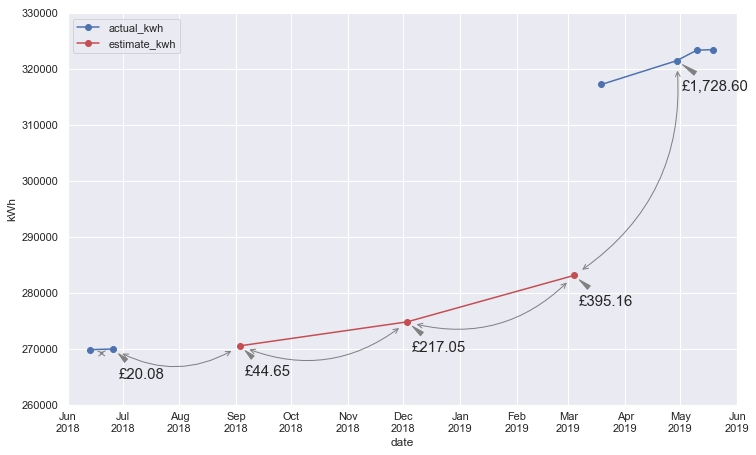

In [175]:
# plot
ax = df.plot(x='date', y=['actual_kwh', 'estimate_kwh'], style=['bo-', 'ro-'], figsize=(12,8))
_ = ax.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-01')])
_ = ax.set_ylim([260000, 330000])
ax.set_ylabel('kWh')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b\n%Y'))
ax.xaxis.set_tick_params(which='major', labelbottom=False)
last_bp = (df.date[0], df.bill_kwh[0])
for i, r in df.dropna(subset=['bill']).iterrows():
    ax.annotate('', (r.date, r.bill_kwh), xytext = last_bp, 
        arrowprops = {'arrowstyle':'<->', 'connectionstyle':'arc3,rad=0.3', 'shrinkA':10, 'shrinkB':10, 'color':'grey'}
        )
    ax.annotate(r.bill, (r.date, r.bill_kwh), xytext = (5,-30), textcoords='offset points', fontsize=15,
        arrowprops = {'arrowstyle':'wedge', 'shrinkA':7, 'shrinkB':7, 'color':'grey'})
    last_bp = (r.date, r.bill_kwh)

## Simple linear regression
As you can see in the plot below, the actual usage rate is roughly 3.5 times higher than the estimate usage rate.

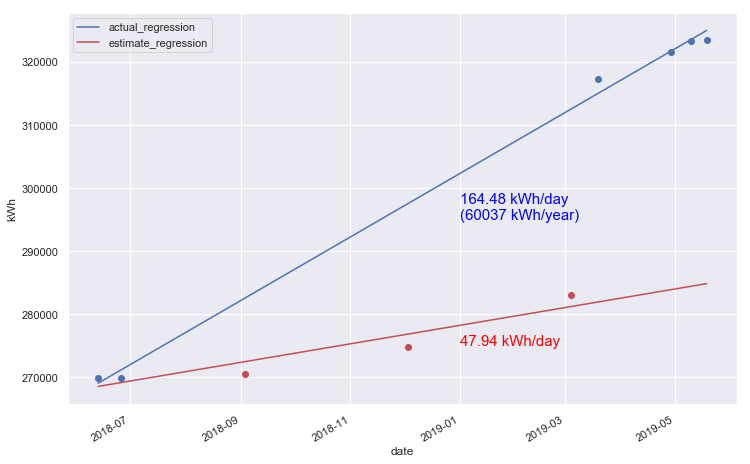

In [176]:
# simple linear regression
## actual readings - remove dates where there's no actual readings
actual_x = df[~df.actual_kwh.isin([np.nan])].days.values
actual_y = df.actual_kwh.dropna().values
actual_rate, actual_start = np.polyfit(actual_x, actual_y, 1)
## British Gas estimates - use the first five "readings"
estimate_x = df.days.values[:5]
estimate_y = df.bill_kwh.values[:5]
estimate_rate, estimate_start = np.polyfit(estimate_x, estimate_y, 1)
## Regression data
regression_df = pd.DataFrame({
    'date': [df['date'].iloc[0], df['date'].iloc[-1]],
    'actual_regression': [actual_start, actual_rate * df['days'].iloc[-1] + actual_start],
    'estimate_regression': [estimate_start, estimate_rate * df['days'].iloc[-1] + estimate_start]
})
## plot graph with regression lines
ax2 = df.plot(x='date', y=['actual_kwh', 'estimate_kwh'], style=['bo', 'ro'], figsize=(12,8), legend=False)
#_ = ax2.set_xlim([pd.Timestamp('2018-06-01'), pd.Timestamp('2019-06-01')])
#_ = ax2.set_ylim([260000, 330000])
ax2.set_ylabel('kWh')
regression_df.plot(ax=ax2, x='date', style=['b', 'r'])
_ = ax2.annotate('{:.2f} kWh/day\n({:.0f} kWh/year)'.format(actual_rate, actual_rate*365), (dates.date2num(pd.Timestamp('2019-01-01')), 295000), color='blue', fontsize=15)
_ = ax2.annotate('{:.2f} kWh/day'.format(estimate_rate), (dates.date2num(pd.Timestamp('2019-01-01')), 275000), color='red', fontsize=15)

## Conclusion
We were told at the time of purchase that 2900 pounds were spent on gas in the last full year by the previous owner. My estimate for our gas bill in the first year is 2500 pounds.

The estimated actual gas usage for the first year is 60000 kWh.

(Note that last winter was quite warm, and we bought and used a few new electric oid-filled radiators, so we potentially didn't used as much gas.)

In the future we should provide regular actual readings so that the bill will reflect the cost of actual usage.